In [45]:
from __future__ import division

import numpy as np
import os
from glob import glob

from PIL import Image
from copy import deepcopy

from sklearn import linear_model, datasets, neighbors
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm

%matplotlib inline
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import pandas as pd

import scipy.stats as stats
from scipy.stats import norm
import sklearn

In [46]:
## define path to input datasets (tidy format)
path_to_recog = '/home/jefan/neurosketch/neurosketch_voxelmat_freesurfer_recog'
path_to_draw = '/home/jefan/neurosketch/neurosketch_voxelmat_freesurfer_drawing'
roi_list = np.array(['V1','V2','LOC','IT','fusiform','parahippo', 'PRC', 'ento','hipp','mOFC'])

In [47]:
## get raw file list for recognition runs
RECOG_METAS = sorted([i for i in os.listdir(path_to_recog) if i.split('.')[-1]=='csv'])
RECOG_FEATS = sorted([i for i in os.listdir(path_to_recog) if i.split('.')[-1]=='npy'])
RECOG_SUBS = np.array([i.split('_')[0] for i in RECOG_FEATS])

recog_sub_list = np.unique(RECOG_SUBS)

def preprocess_recog(RECOG_METAS, RECOG_FEATS):
    M = [i for i in RECOG_METAS if len(i.split('.')[0].split('_'))==4]
    F = [i for i in RECOG_FEATS if len(i.split('.')[0].split('_'))==4]
    return M,F

RECOG_METAS, RECOG_FEATS = preprocess_recog(RECOG_METAS, RECOG_FEATS)

In [48]:
## get raw file list for drawing runs
DRAW_METAS = sorted([i for i in os.listdir(path_to_draw) if i.split('.')[-1]=='csv'])
DRAW_FEATS = sorted([i for i in os.listdir(path_to_draw) if i.split('.')[-1]=='npy'])
DRAW_SUBS = np.array([i.split('_')[0] for i in DRAW_FEATS])
draw_sub_list = np.unique(DRAW_SUBS)

In [49]:
## get subject ID's that have complete datasets from all phases of experiment
sub_list = np.intersect1d(recog_sub_list,draw_sub_list)
print 'Number of subs: {}'.format(len(sub_list))

Number of subs: 31


In [50]:
## filter file list so only contains the sessions that have full datasets
def extract_good_sessions(DRAW_METAS,DRAW_FEATS,RECOG_METAS,RECOG_FEATS):
    _DRAW_METAS = [i for i in DRAW_METAS if i.split('_')[1] in sub_list]
    _DRAW_FEATS = [i for i in DRAW_FEATS if i.split('_')[0] in sub_list]
    _RECOG_METAS = [i for i in RECOG_METAS if i.split('_')[1] in sub_list]
    _RECOG_FEATS = [i for i in RECOG_FEATS if i.split('_')[0] in sub_list]
    return _DRAW_METAS, _DRAW_FEATS, _RECOG_METAS, _RECOG_FEATS

DRAW_METAS,DRAW_FEATS,RECOG_METAS,RECOG_FEATS =  \
extract_good_sessions(DRAW_METAS,DRAW_FEATS,RECOG_METAS,RECOG_FEATS)

RECOG_SUBS = np.array([i.split('_')[0]+'_neurosketch' for i in RECOG_FEATS])
RECOG_ROIS = np.array([i.split('_')[1] for i in RECOG_FEATS])

DRAW_SUBS = np.array([i.split('_')[0]+'_neurosketch' for i in DRAW_FEATS])
DRAW_ROIS = np.array([i.split('_')[1] for i in DRAW_FEATS])

### How well do we do at classifying the target when we train on recognition patterns only?

In [201]:
#### Helper data loader functions
def load_draw_meta(this_sub):
    this_file = 'metadata_{}_drawing.csv'.format(this_sub)
    x = pd.read_csv(os.path.join(path_to_draw,this_file))
    x = x.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)
    x['trial_num'] = np.repeat(np.arange(40),23)        
    return x
    
def load_draw_feats(this_sub,this_roi):
    this_file = '{}_{}_featurematrix.npy'.format(this_sub,this_roi)
    y = np.load(os.path.join(path_to_draw,this_file))
    y = y.transpose()
    return y

def load_draw_data(this_sub,this_roi):
    x = load_draw_meta(this_sub)
    y = load_draw_feats(this_sub,this_roi)
    assert y.shape[0] == x.shape[0]    
    return x,y

def load_recog_meta(this_sub,this_roi,this_phase):
    this_file = 'metadata_{}_{}_{}.csv'.format(this_sub,this_roi,this_phase)
    x = pd.read_csv(os.path.join(path_to_recog,this_file))
    x = x.drop(['Unnamed: 0'], axis=1)
    return x
    
def load_recog_feats(this_sub,this_roi,this_phase):
    this_file = '{}_{}_{}_featurematrix.npy'.format(this_sub,this_roi,this_phase)
    y = np.load(os.path.join(path_to_recog,this_file))
    y = y.transpose()
    return y    

def load_recog_data(this_sub,this_roi,this_phase):
    x = load_recog_meta(this_sub,this_roi,this_phase)
    y = load_recog_feats(this_sub,this_roi,this_phase)
    assert y.shape[0] == x.shape[0]    
    return x,y

# z-score normalization to de-mean & standardize variances within-voxel 
def normalize(X):
    X = X - X.mean(0)
    X = X / np.maximum(X.std(0), 1e-5)
    return X

In [269]:
## example subject, roi, and phase (localizer is default)
this_sub = sub_list[0]
this_roi = roi_list[2] ## order is: ['V1','V2','LOC','IT','fusiform','parahippo', 'PRC', 'ento','hipp','mOFC']
this_phase = '12' ## options are '12', '34', '56'

In [270]:
RM, RF = load_recog_data(this_sub,this_roi,this_phase)
DM, DF = load_draw_data(this_sub,this_roi)
assert RF.shape[1]==DF.shape[1] ## that number of voxels is identical

In [271]:
## normalize voxels within task
normalize_on = 1
if normalize_on:
    _RF = normalize(RF)
    _DF = normalize(DF)
else:
    _RF = RF
    _DF = DF

In [272]:
# single train/test split
X_train = _RF
y_train = RM.label.values
X_test = _DF
y_test = DM.label.values
# clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
clf = linear_model.LogisticRegression(penalty='l2',C=1).fit(X_train, y_train)
print clf.score(X_test, y_test)

0.327173913043


In [273]:
cats = clf.classes_
probs = clf.predict_proba(X_test)
DM['bed_prob'] = probs[:,0]
DM['bench_prob'] = probs[:,1]
DM['chair_prob'] = probs[:,2]
DM['table_prob'] = probs[:,3]

In [274]:
x = DM[DM.label=='bed']['time_point']
y = DM[DM.label=='bed']['bed_prob']

In [275]:
## general plotting params
sns.set_context('poster')
colors = sns.color_palette("cubehelix", 5)

(0, 1)

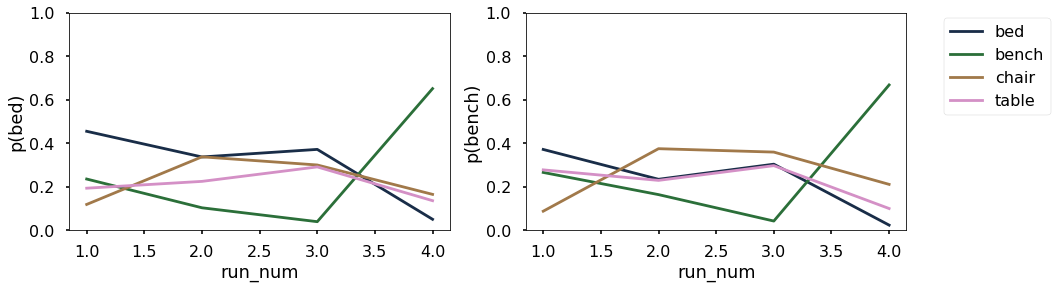

In [289]:
iv = 'run_num' ## options: time_point, trial_num, run_num
trained_objs = np.unique(DM.label.values)

plt.figure(figsize=(15,4))
plt.subplot(121)
target = trained_objs[0]
plt.plot(DM[DM.label==target].groupby(iv)['bed_prob'].mean(),color=colors[0],label='bed')
plt.plot(DM[DM.label==target].groupby(iv)['bench_prob'].mean(),color=colors[1],label='bench')
plt.plot(DM[DM.label==target].groupby(iv)['chair_prob'].mean(),color=colors[2],label='chair')
plt.plot(DM[DM.label==target].groupby(iv)['table_prob'].mean(),color=colors[3],label='table')
# plt.legend(bbox_to_anchor=(1.4, 1.01))
plt.xlabel(iv)
plt.ylabel('p({})'.format(target))
plt.ylim(0,1)

plt.subplot(122)
target = trained_objs[1]
plt.plot(DM[DM.label==target].groupby(iv)['bed_prob'].mean(),color=colors[0],label='bed')
plt.plot(DM[DM.label==target].groupby(iv)['bench_prob'].mean(),color=colors[1],label='bench')
plt.plot(DM[DM.label==target].groupby(iv)['chair_prob'].mean(),color=colors[2],label='chair')
plt.plot(DM[DM.label==target].groupby(iv)['table_prob'].mean(),color=colors[3],label='table')
plt.legend(bbox_to_anchor=(1.4, 1.01))
plt.xlabel(iv)
plt.ylabel('p({})'.format(target))
plt.ylim(0,1)

In [293]:
iv = 'trial_num' ## options: time_point, trial_num, run_num
trained_objs = np.unique(DM.label.values)

target = trained_objs[0]
# plt.plot(DM[DM.label==target].groupby(iv)['{}_prob'.format(target)].mean(),color=colors[0],label=target)
DM[DM.label==target].groupby(iv)['{}_prob'.format(target)].mean().values

array([ 0.64967748,  0.39603186,  0.4946188 ,  0.26045755,  0.47101727,
        0.23354446,  0.40163374,  0.2699671 ,  0.39510254,  0.38141003,
        0.26651996,  0.38768468,  0.45806012,  0.33452529,  0.40909468,
        0.0349668 ,  0.01511623,  0.09921649,  0.06472103,  0.03450699])

In [294]:
target = trained_objs[1]
DM[DM.label==target].groupby(iv)['{}_prob'.format(target)].mean().values

array([ 0.45051986,  0.10530875,  0.28219171,  0.22703916,  0.26084919,
        0.09421186,  0.24108418,  0.16101077,  0.14574483,  0.17401957,
        0.05459478,  0.00969809,  0.07864588,  0.03212571,  0.03322477,
        0.69647791,  0.73322818,  0.5804743 ,  0.7213191 ,  0.60616553])

In [328]:
def get_prob_timecourse(iv,DM):
    trained_objs = np.unique(DM.label.values)
    control_objs = [i for i in ['bed','bench','chair','table'] if i not in trained_objs]
    t1 = trained_objs[0]
    t2 = trained_objs[1]
    c1 = control_objs[0]
    c2 = control_objs[1]
    target = np.vstack((DM[DM.label==t1].groupby(iv)['{}_prob'.format(t1)].mean().values,
                   DM[DM.label==t2].groupby(iv)['{}_prob'.format(t2)].mean().values)).mean(0) ## target timecourse
    foil = np.vstack((DM[DM.label==t1].groupby(iv)['{}_prob'.format(t2)].mean().values,
                   DM[DM.label==t2].groupby(iv)['{}_prob'.format(t1)].mean().values)).mean(0) ## foil timecourse
    control = np.vstack((DM[DM.label==t1].groupby(iv)['{}_prob'.format(c1)].mean().values,
                        DM[DM.label==t1].groupby(iv)['{}_prob'.format(c2)].mean().values,
                        DM[DM.label==t2].groupby(iv)['{}_prob'.format(c1)].mean().values,
                        DM[DM.label==t2].groupby(iv)['{}_prob'.format(c2)].mean().values)).mean(0) ## control timecourse
    
    return target, foil, control
    
    

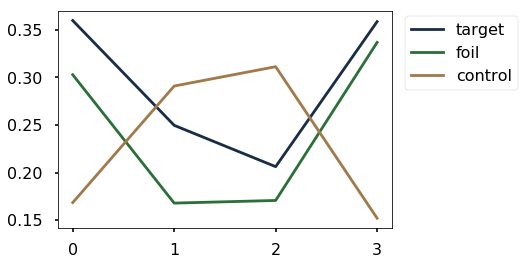

In [339]:
t,f,c = get_prob_timecourse('run_num',DM)
plt.plot(t,color=colors[0],label='target')
plt.plot(f,color=colors[1],label='foil')
plt.plot(c,color=colors[2],label='control')
plt.legend(bbox_to_anchor=(1.4, 1.01))

In [331]:
t.shape

(20,)